In [3]:
from math import log
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
%matplotlib inline
import matplotlib.pyplot as plt
from pycbc.types.frequencyseries import FrequencySeries
from pycbc.cosmology import redshift, cosmological_quantity_from_redshift
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.utils import taper_timeseries, td_taper
from pycbc.filter.matchedfilter import sigma
from pycbc.psd.read import from_txt
from tqdm import tqdm

In [4]:
def strain_generator(det='ET-D', signal_type='BBH', model='IMRPhenomD', fs=4096, df=None,
                     flow=2, fref=2, tc=0, params=None, fd_taper=False, rotation=False, domain='frequency'):

    if domain == 'time':
        if signal_type == "BBH":
            # Generate a waveform at the detector-frame.
            hp, hc = get_td_waveform(approximant=model, 
                        mass1=params['mass1'], mass2=params['mass2'],
                        spin1x=params['spin1x'], spin1y=params['spin1y'],
                        spin1z=params['spin1z'], spin2x=params['spin2x'],
                        spin2y=params['spin2y'], spin2z=params['spin2z'],
                        distance=params['distance'], coa_phase=params['coa_phase'],
                        inclination=params['inclination'], f_lower=flow,
                        f_ref=fref, delta_t=1.0/fs)

        elif signal_type in ["NSBH", "BNS"]:
            # Generate a waveform at the detector-frame.
            hp, hc = get_td_waveform(approximant=model, 
                        mass1=params['mass1'], mass2=params['mass2'],
                        spin1z=params['spin1z'],
                        spin2z=params['spin2z'],
                        distance=params['distance'], coa_phase=params['coa_phase'],
                        inclination=params['inclination'], f_lower=flow,
                        f_ref=fref, delta_t=1.0/fs)

        else:
            raise ValueError("`signal_type` must be chosen from ['BBH', 'BNS', 'NSBH'].")

        # Set merger time to 'tc'.
        hp.start_time += tc
        hc.start_time += tc

        # Project GW waveform onto GW detectors.
        ra = params['ra']
        dec = params['dec']
        psi = params['polarization']
        time = hp.start_time

        if det == 'ET-D':
            det_1 = Detector("E1")
            det_2 = Detector("E2")
            det_3 = Detector("E3")
            num_detectors = 3
        elif det == 'CE':  #  Assume same position and orientation as aLIGO.
            det_1 = Detector("H1")
            det_2 = Detector("L1")
            num_detectors = 2
        else:
            raise NotImplementedError("No such detector.")

        fp_1, fc_1 = det_1.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
        fp_2, fc_2 = det_2.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
        if num_detectors == 3:
            fp_3, fc_3 = det_3.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

        if rotation == True:
            # Take the rotation of the earth into account by using the "project_wave" function.
            ht_1 = det_1.project_wave(hp=hp, hc=hc, ra=ra, dec=dec, polarization=psi)
            ht_2 = det_2.project_wave(hp=hp, hc=hc, ra=ra, dec=dec, polarization=psi)
            ht_list = [ht_1, ht_2]
            if num_detectors == 3:
                ht_3 = det_3.project_wave(hp=hp, hc=hc, ra=ra, dec=dec, polarization=psi)
                ht_list.append(ht_3)
        else:
            # Not take the rotation of the earth into account.
            ht_1 = fp_1*hp + fc_1*hc
            ht_2 = fp_2*hp + fc_2*hc
            ht_list = [ht_1, ht_2]
            if num_detectors == 3:
                ht_3 = fp_3*hp + fc_3*hc
                ht_list.append(ht_3)

        return ht_list

    else:
        if signal_type == "BBH":
            sptilde, sctilde = get_fd_waveform(approximant=model, 
                                    mass1=params['mass1'], mass2=params['mass2'],
                                    spin1x=params['spin1x'], spin1y=params['spin1y'],
                                    spin1z=params['spin1z'], spin2x=params['spin2x'],
                                    spin2y=params['spin2y'], spin2z=params['spin2z'],
                                    distance=params['distance'], coa_phase=params['coa_phase'],
                                    inclination=params['inclination'], f_lower=flow,
                                    f_ref=fref, delta_f=df)
        elif signal_type in ["NSBH", "BNS"]:
            sptilde, sctilde = get_fd_waveform(approximant=model, 
                                    mass1=params['mass1'], mass2=params['mass2'],
                                    spin1z=params['spin1z'],
                                    spin2z=params['spin2z'],
                                    distance=params['distance'], coa_phase=params['coa_phase'],
                                    inclination=params['inclination'], f_lower=flow,
                                    f_ref=fref, delta_f=df)
        else:
            raise ValueError("`signal_type` must be chosen from ['BBH', 'BNS', 'NSBH'].")

        return FrequencySeries(sptilde, delta_f=df, epoch=None)


def optimal_snr(strain, fs, psd_path, flow, taper=False, is_asd_file=True, domain='frequency'):
    if domain == 'time':
        td_length = strain.duration
        delta_f = 1.0/td_length
        if taper == False:
            strain_freq = strain.to_frequencyseries(delta_f)
        else:
            strain_freq = taper_timeseries(strain, tapermethod='TAPER_STARTEND').to_frequencyseries(delta_f)
        N = int(td_length*fs)
        fd_length = int(N/2 + 1)
        psd = from_txt(filename=psd_path, length=fd_length, delta_f=delta_f, low_freq_cutoff=flow, is_asd_file=is_asd_file)
    else:
        psd = from_txt(filename=psd_path, length=len(strain), delta_f=strain.delta_f, low_freq_cutoff=flow, is_asd_file=is_asd_file)
        strain_freq = strain
    snr_opt = sigma(htilde=strain_freq, psd=psd, low_frequency_cutoff=flow, high_frequency_cutoff=fs/2)        
    return snr_opt


def opt_snr_calculator(det='ET-D', signal_type='BBH', model='IMRPhenomD', psd_path=None, is_asd_file=True, fs=4096, df=1./100,
                       flow=2, fref=2, tc=1126259462.0, params=None, rotation=False, taper=False, domain='frequency'):

    if det == 'ET-D':
        ave_ra = 0
        ave_dec = 0
        for detector_name in ['E1', 'E2', 'E3']:
            detector = Detector(detector_name)
            ra, dec = detector.optimal_orientation(t_gps=tc)
            ave_ra += ra
            ave_dec += dec
        ra, dec = ave_ra/3, ave_dec/3
    elif det == 'CE':
        detector_name = 'H1'
        detector = Detector(detector_name)
        ra, dec = detector.optimal_orientation(t_gps=tc)
    else:
        raise NotImplementedError("No such detector.")

    params['ra'] = ra
    params['dec'] = dec
   
    strain = strain_generator(det=det, signal_type=signal_type, model=model, fs=fs, df=df,
                              flow=flow, fref=fref, tc=tc, params=params, rotation=rotation, domain=domain)

    if det == 'CE':
        strain = strain_generator(det=det, signal_type=signal_type, model=model, fs=fs, df=df,
                                    flow=flow, fref=fref, tc=tc, params=params, rotation=rotation, domain=domain)
        if domain == 'time':
            snr = optimal_snr(strain=strain[0], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
        else:
            snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
        return snr

    elif det == 'ET-D':
        network_snr_sq = 0
        for index in range(1):
            if domain == 'time':
                snr = optimal_snr(strain=strain[index], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
            else:
                snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                snr *= np.sqrt(3)/2  # For the frequency-domain, there's no antenna pattern to include the opening angle factor.
        network_snr_sq = 3*snr**2    # Three V-shape detectors.
        return np.sqrt(network_snr_sq)

    else:
        raise NotImplementedError("No such detector.")


## 1. Total CBC

In [5]:
# CE

design_asd_path_CE = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
total_psd_path_CE_upperrate = "./total_psd_CE_mean_upperrate.txt"
total_psd_path_CE_medianrate = "./total_psd_CE_mean_medianrate.txt"

# ET-D

design_asd_path_ET = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
total_psd_path_ET_upperrate = "./total_psd_ETD_mean_upperrate.txt"
total_psd_path_ET_medianrate = "./total_psd_ETD_mean_medianrate.txt"

In [21]:
det_mass_array = np.logspace(np.log10(0.5), np.log10(2000), 200)
total_det_mass = np.array(det_mass_array)*2
opt_snr_loss_CE_median = []
opt_snr_loss_CE_upper = []
opt_snr_design_CE = []
opt_snr_total_upperrate_CE = []
opt_snr_total_medianrate_CE = []

opt_snr_loss_ET_median = []
opt_snr_loss_ET_upper = []
opt_snr_design_ET = []
opt_snr_total_upperrate_ET = []
opt_snr_total_medianrate_ET = []

model = 'IMRPhenomD'

for i in tqdm(range(len(det_mass_array))):
    dl = 440 # Mpc
    z = redshift(dl)
    signal_params = {'mass1': det_mass_array[i], 'mass2': det_mass_array[i], 'spin1x': 0, 'spin1y': 0, 'spin1z': 0, 'spin2x': 0, 'spin2y': 0, 'spin2z': 0, 
                     'distance': dl, 'coa_phase': 0, 'inclination': 0, 'polarization': 0}
    opt_snr_design_CE.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=design_asd_path_CE, is_asd_file=True, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_medianrate_CE.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=total_psd_path_CE_medianrate, is_asd_file=False, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_upperrate_CE.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=total_psd_path_CE_upperrate, is_asd_file=False, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))

    opt_snr_design_ET.append(opt_snr_calculator(det='ET-D', signal_type='BBH', model=model, psd_path=design_asd_path_ET, is_asd_file=True, fs=4096, df=1./100,
                             flow=2, fref=2, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_medianrate_ET.append(opt_snr_calculator(det='ET-D', signal_type='BBH', model=model, psd_path=total_psd_path_ET_medianrate, is_asd_file=False, fs=4096, df=1./100,
                             flow=2, fref=2, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_upperrate_ET.append(opt_snr_calculator(det='ET-D', signal_type='BBH', model=model, psd_path=total_psd_path_ET_upperrate, is_asd_file=False, fs=4096, df=1./100,
                             flow=2, fref=2, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))

for i in range(len(opt_snr_design_CE)):
    opt_snr_loss_CE_median.append(1 - opt_snr_total_medianrate_CE[i]/opt_snr_design_CE[i])
    opt_snr_loss_CE_upper.append(1 - opt_snr_total_upperrate_CE[i]/opt_snr_design_CE[i])

for i in range(len(opt_snr_design_ET)):
    opt_snr_loss_ET_median.append(1 - opt_snr_total_medianrate_ET[i]/opt_snr_design_ET[i])
    opt_snr_loss_ET_upper.append(1 - opt_snr_total_upperrate_ET[i]/opt_snr_design_ET[i])

100%|██████████| 200/200 [04:55<00:00,  1.48s/it]


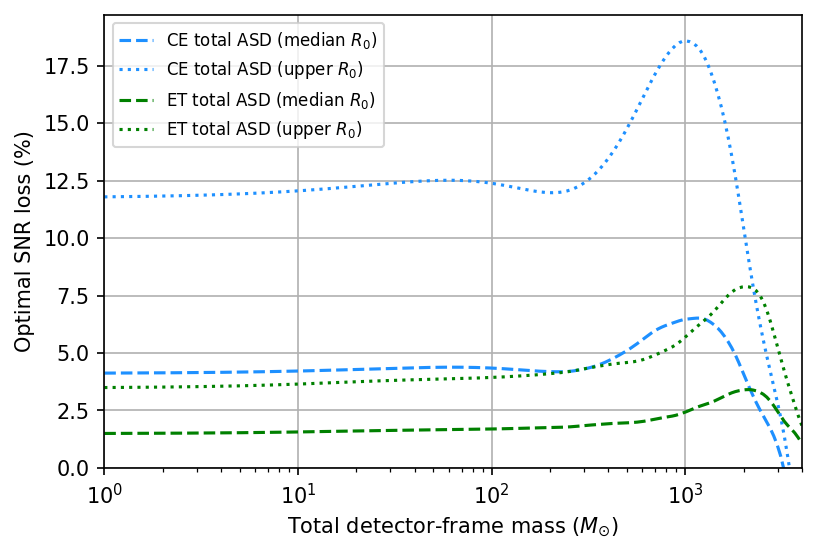

In [22]:
plt.figure(dpi=150)

plt.semilogx(total_det_mass, np.array(opt_snr_loss_CE_median)*100, color='dodgerblue', linestyle='dashed', label=r'CE total ASD (median $R_0$)')
plt.semilogx(total_det_mass, np.array(opt_snr_loss_CE_upper)*100, color='dodgerblue', linestyle='dotted', label=r'CE total ASD (upper $R_0$)')
plt.semilogx(total_det_mass, np.array(opt_snr_loss_ET_median)*100, color='green', linestyle='dashed', label=r'ET total ASD (median $R_0$)')
plt.semilogx(total_det_mass, np.array(opt_snr_loss_ET_upper)*100, color='green', linestyle='dotted', label=r'ET total ASD (upper $R_0$)')
plt.xlabel(r"Total detector-frame mass ($M_{\odot}$)")
plt.ylabel("Optimal SNR loss (%)")
plt.xlim(1, 4000)
plt.ylim(0, )
plt.grid()
plt.legend(fontsize=8)
plt.savefig('optsnr_loss_CE_ET_detframe_totM_IMRPhenomD_total.png', dpi=500)
plt.show()

In [8]:
print(np.array(opt_snr_loss_CE_median)*100)
print(np.array(opt_snr_loss_CE_upper)*100)

[4.12119381 4.12308829 4.12522075 4.12762528 4.13034075 4.1334113
 4.13688671 4.14082239 4.14527897 4.15032139 4.15601701 4.16243267
 4.16963035 4.17766252 4.18656957 4.19638569 4.20721112 4.21909886
 4.2319678  4.24575377 4.26037466 4.2756982  4.29148295 4.30742713
 4.32323384 4.33854305 4.35253289 4.36464229 4.37403616 4.37917675
 4.37804573 4.37019661 4.35537626 4.33239041 4.30177767 4.26654539
 4.22874456 4.1970841  4.18040353 4.18902893 4.25092187 4.3651301
 4.53966625 4.78093708 5.07438542 5.42404844 5.81144825 6.11782377
 6.31148593 6.46265823]
[11.79490685 11.80040426 11.80659451 11.81357717 11.82146583 11.83038948
 11.84049349 11.8519396  11.8649047  11.87957773 11.89615408 11.91482644
 11.935772   11.95913833 11.98503499 12.01355162 12.04497317 12.07943523
 12.11667815 12.1564751  12.19851703 12.2423469  12.28727402 12.33240218
 12.37666622 12.41870773 12.45637885 12.48754554 12.50940042 12.51820525
 12.50969678 12.4815071  12.43196897 12.35980659 12.26926363 12.16906385
 12.

In [9]:
print(np.array(opt_snr_loss_ET_median)*100)
print(np.array(opt_snr_loss_ET_upper)*100)

[1.49420976 1.49556575 1.49709289 1.49881601 1.50076357 1.50296804
 1.50546616 1.50829895 1.51151124 1.51515074 1.51926626 1.52390474
 1.52910652 1.53490025 1.54129887 1.5482998  1.5559309  1.56416838
 1.5728678  1.58188657 1.59107224 1.60023891 1.60909604 1.61739441
 1.62514474 1.63255375 1.63919078 1.64538903 1.65237442 1.65942286
 1.66509854 1.67166863 1.68081302 1.69103976 1.7019713  1.71577363
 1.72919735 1.74433581 1.75791602 1.77376623 1.81272981 1.85889173
 1.89870559 1.93286148 1.95392981 1.98917878 2.06961204 2.1694844
 2.2598006  2.42195465]
[3.49261841 3.49578407 3.49934976 3.50337358 3.50792217 3.51307153
 3.5189077  3.52552672 3.53303364 3.54154024 3.55116072 3.56200463
 3.57416642 3.5877133  3.60267538 3.61904751 3.63689716 3.6561628
 3.67651082 3.69759581 3.71901858 3.74031049 3.76088614 3.78024525
 3.7982205  3.81492705 3.82991358 3.84323043 3.8571814  3.87144061
 3.88464686 3.8994619  3.91832168 3.94029509 3.96507384 3.99604348
 4.02928551 4.06969467 4.11609965 4.1721

In [10]:
def f_isco(m1,m2):
    G = 6.67384e-11
    SM = 1.9891e30
    C = 299792458
    M = m1+m2
    fisco = C**3/(6*np.sqrt(6)*np.pi*G*M*SM)
    return fisco

In [11]:
print(f_isco(500, 500))

4.395952110201331


## 2. BNS cases

In [12]:
# CE

design_asd_path_CE = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"

psd_nosubtraction_CE_median = pd.read_csv('psd_nosubtraction_CE_median_512s_16s_5h.csv')
psd_nosubtraction_CE_median = np.array(psd_nosubtraction_CE_median).T
mean_psd_nosubtraction_CE_median = np.mean(psd_nosubtraction_CE_median[1:], axis=0)
file = open("./mean_psd_nosubtraction_CE_median.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(mean_psd_nosubtraction_CE_median)):
    file.write("%.18f \t\t %.18e\n" % (psd_nosubtraction_CE_median[0:][0][i], mean_psd_nosubtraction_CE_median[i]))
file.close()
mean_psd_nosubtraction_CE_median = "./mean_psd_nosubtraction_CE_median.txt"

psd_snr7p0_CE_median = pd.read_csv('psd_snr7p0_CE_median_512s_16s_5h.csv')
psd_snr7p0_CE_median = np.array(psd_snr7p0_CE_median).T
mean_psd_snr7p0_CE_median = np.mean(psd_snr7p0_CE_median[1:], axis=0)
file = open("./mean_psd_snr7p0_CE_median.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(mean_psd_snr7p0_CE_median)):
    file.write("%.18f \t\t %.18e\n" % (psd_snr7p0_CE_median[0:][0][i], mean_psd_snr7p0_CE_median[i]))
file.close()
mean_psd_snr7p0_CE_median = "./mean_psd_snr7p0_CE_median.txt"


psd_nosubtraction_CE_upper = pd.read_csv('psd_nosubtraction_CE_upper_512s_16s_5h.csv')
psd_nosubtraction_CE_upper = np.array(psd_nosubtraction_CE_upper).T
mean_psd_nosubtraction_CE_upper = np.mean(psd_nosubtraction_CE_upper[1:], axis=0)
file = open("./mean_psd_nosubtraction_CE_upper.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(mean_psd_nosubtraction_CE_upper)):
    file.write("%.18f \t\t %.18e\n" % (psd_nosubtraction_CE_upper[0:][0][i], mean_psd_nosubtraction_CE_upper[i]))
file.close()
mean_psd_nosubtraction_CE_upper = "./mean_psd_nosubtraction_CE_upper.txt"

psd_snr7p0_CE_upper = pd.read_csv('psd_snr7p0_CE_upper_512s_16s_5h.csv')
psd_snr7p0_CE_upper = np.array(psd_snr7p0_CE_upper).T
mean_psd_snr7p0_CE_upper = np.mean(psd_snr7p0_CE_upper[1:], axis=0)
file = open("./mean_psd_snr7p0_CE_upper.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(mean_psd_snr7p0_CE_upper)):
    file.write("%.18f \t\t %.18e\n" % (psd_snr7p0_CE_upper[0:][0][i], mean_psd_snr7p0_CE_upper[i]))
file.close()
mean_psd_snr7p0_CE_upper = "./mean_psd_snr7p0_CE_upper.txt"

# ET-D

design_asd_path_ETD = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"

psd_nosubtraction_ETD_median = pd.read_csv('psd_nosubtraction_ETD_median_512s_16s_5h.csv')
psd_nosubtraction_ETD_median = np.array(psd_nosubtraction_ETD_median).T
mean_psd_nosubtraction_ETD_median = np.mean(psd_nosubtraction_ETD_median[1:], axis=0)
file = open("./mean_psd_nosubtraction_ETD_median.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(mean_psd_nosubtraction_ETD_median)):
    file.write("%.18f \t\t %.18e\n" % (psd_nosubtraction_ETD_median[0:][0][i], mean_psd_nosubtraction_ETD_median[i]))
file.close()
mean_psd_nosubtraction_ETD_median = "./mean_psd_nosubtraction_ETD_median.txt"

psd_nosubtraction_ETD_upper = pd.read_csv('psd_nosubtraction_ETD_upper_512s_16s_5h.csv')
psd_nosubtraction_ETD_upper = np.array(psd_nosubtraction_ETD_upper).T
mean_psd_nosubtraction_ETD_upper = np.mean(psd_nosubtraction_ETD_upper[1:], axis=0)
file = open("./mean_psd_nosubtraction_ETD_upper.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(mean_psd_nosubtraction_ETD_upper)):
    file.write("%.18f \t\t %.18e\n" % (psd_nosubtraction_ETD_upper[0:][0][i], mean_psd_nosubtraction_ETD_upper[i]))
file.close()
mean_psd_nosubtraction_ETD_upper = "./mean_psd_nosubtraction_ETD_upper.txt"


In [18]:
det_mass_array = np.logspace(np.log10(0.5), np.log10(2000), 200)
total_det_mass = np.array(det_mass_array)*2
opt_snr_design_CE_bns = []
opt_snr_loss_CE_median_bns = []
opt_snr_loss_CE_median_snr7p0_bns = []
opt_snr_total_medianrate_CE_no_bns = []
opt_snr_total_medianrate_CE_snr7p0_bns = []

opt_snr_loss_CE_upper_bns = []
opt_snr_loss_CE_upper_snr7p0_bns = []
opt_snr_total_upperrate_CE_no_bns = []
opt_snr_total_upperrate_CE_snr7p0_bns = []

opt_snr_design_ETD_bns = []
opt_snr_loss_ETD_median_bns = []
opt_snr_total_medianrate_ETD_no_bns = []

opt_snr_loss_ETD_upper_bns = []
opt_snr_total_upperrate_ETD_no_bns = []

model = 'IMRPhenomD'

for i in tqdm(range(len(det_mass_array))):
    dl = 440 # Mpc
    z = redshift(dl)
    signal_params = {'mass1': det_mass_array[i], 'mass2': det_mass_array[i], 'spin1x': 0, 'spin1y': 0, 'spin1z': 0, 'spin2x': 0, 'spin2y': 0, 'spin2z': 0, 
                     'distance': dl, 'coa_phase': 0, 'inclination': 0, 'polarization': 0}
    opt_snr_design_CE_bns.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=design_asd_path_CE, is_asd_file=True, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_medianrate_CE_no_bns.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=mean_psd_nosubtraction_CE_median, is_asd_file=False, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_medianrate_CE_snr7p0_bns.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=mean_psd_snr7p0_CE_median, is_asd_file=False, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_upperrate_CE_no_bns.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=mean_psd_nosubtraction_CE_upper, is_asd_file=False, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_upperrate_CE_snr7p0_bns.append(opt_snr_calculator(det='CE', signal_type='BBH', model=model, psd_path=mean_psd_snr7p0_CE_upper, is_asd_file=False, fs=4096, df=1./100,
                             flow=5, fref=5, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))

    opt_snr_design_ETD_bns.append(opt_snr_calculator(det='ET-D', signal_type='BBH', model=model, psd_path=design_asd_path_ETD, is_asd_file=True, fs=4096, df=1./100,
                             flow=2, fref=2, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_medianrate_ETD_no_bns.append(opt_snr_calculator(det='ET-D', signal_type='BBH', model=model, psd_path=mean_psd_nosubtraction_ETD_median, is_asd_file=False, fs=4096, df=1./100,
                             flow=2, fref=2, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))
    opt_snr_total_upperrate_ETD_no_bns.append(opt_snr_calculator(det='ET-D', signal_type='BBH', model=model, psd_path=mean_psd_nosubtraction_ETD_upper, is_asd_file=False, fs=4096, df=1./100,
                             flow=2, fref=2, tc=1126259462.0, params=signal_params, rotation=False, taper=False, domain='frequency'))

for i in range(len(opt_snr_design_CE_bns)):
    opt_snr_loss_CE_median_bns.append(1 - opt_snr_total_medianrate_CE_no_bns[i]/opt_snr_design_CE_bns[i])
    opt_snr_loss_CE_median_snr7p0_bns.append(1 - opt_snr_total_medianrate_CE_snr7p0_bns[i]/opt_snr_design_CE_bns[i])
    opt_snr_loss_CE_upper_bns.append(1 - opt_snr_total_upperrate_CE_no_bns[i]/opt_snr_design_CE_bns[i])
    opt_snr_loss_CE_upper_snr7p0_bns.append(1 - opt_snr_total_upperrate_CE_snr7p0_bns[i]/opt_snr_design_CE_bns[i])

    opt_snr_loss_ETD_median_bns.append(1 - opt_snr_total_medianrate_ETD_no_bns[i]/opt_snr_design_ETD_bns[i])
    opt_snr_loss_ETD_upper_bns.append(1 - opt_snr_total_upperrate_ETD_no_bns[i]/opt_snr_design_ETD_bns[i])


100%|██████████| 200/200 [06:49<00:00,  2.05s/it]


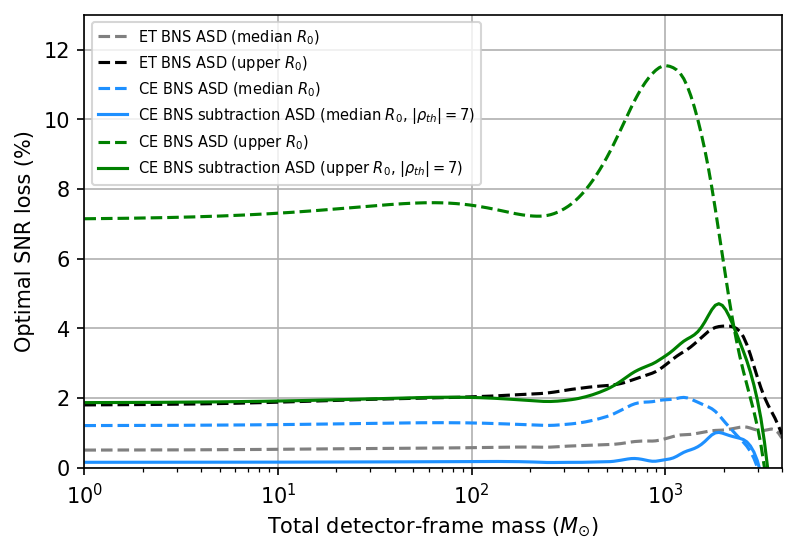

In [19]:
plt.figure(dpi=150)

plt.semilogx(total_det_mass, np.array(opt_snr_loss_ETD_median_bns)*100, color='gray', linestyle='dashed', label=r'ET BNS ASD (median $R_0$)')
plt.semilogx(total_det_mass, np.array(opt_snr_loss_ETD_upper_bns)*100, color='black', linestyle='dashed', label=r'ET BNS ASD (upper $R_0$)')

plt.semilogx(total_det_mass, np.array(opt_snr_loss_CE_median_bns)*100, color='dodgerblue', linestyle='dashed', label=r'CE BNS ASD (median $R_0$)')
plt.semilogx(total_det_mass, np.array(opt_snr_loss_CE_median_snr7p0_bns)*100, color='dodgerblue', linestyle='solid', label=r'CE BNS subtraction ASD (median $R_0$, $\left| \rho_{th} \right|=7$)')
plt.semilogx(total_det_mass, np.array(opt_snr_loss_CE_upper_bns)*100, color='green', linestyle='dashed', label=r'CE BNS ASD (upper $R_0$)')
plt.semilogx(total_det_mass, np.array(opt_snr_loss_CE_upper_snr7p0_bns)*100, color='green', linestyle='solid', label=r'CE BNS subtraction ASD (upper $R_0$, $\left| \rho_{th} \right|=7$)')

plt.xlabel(r"Total detector-frame mass ($M_{\odot}$)")
plt.ylabel("Optimal SNR loss (%)")
plt.xlim(1, 4000)
plt.ylim(0, 13)
plt.grid()
plt.legend(loc='upper left', fontsize=7)
plt.savefig('optsnr_loss_CE_detframe_totM_IMRPhenomD_bns.png', dpi=500)
plt.show()

In [13]:
print(np.array(opt_snr_loss_ETD_median_bns)*100)
print(np.array(opt_snr_loss_ETD_upper_bns)*100)

[0.50735977 0.50782351 0.50834572 0.5089349  0.50960075 0.51035434
 0.51120821 0.51217633 0.51327388 0.51451706 0.51592242 0.51750594
 0.51928104 0.52125696 0.52343753 0.5258205  0.52841359 0.53121022
 0.53415659 0.53720681 0.5403261  0.54346377 0.5464687  0.54921491
 0.55179752 0.55445793 0.55678502 0.55925207 0.56251647 0.56566903
 0.56727404 0.56947427 0.57376757 0.57852078 0.58307221 0.58931086
 0.59246536 0.59457475 0.59301103 0.58998739 0.60549159 0.62411889
 0.6373022  0.65199867 0.6613266  0.6840897  0.73318623 0.76615952
 0.76749128 0.83368613]
[1.80378673 1.80542744 1.80727526 1.80936027 1.81171692 1.81438453
 1.81740762 1.82083586 1.82472363 1.82912878 1.8341106  1.83972611
 1.84602456 1.85304121 1.86079247 1.8692762  1.87852723 1.88851665
 1.89907143 1.91001779 1.92116498 1.93228324 1.94303372 1.9531248
 1.96252909 1.9714205  1.97935765 1.98663167 1.99459099 2.00264642
 2.00939178 2.01716433 2.02783425 2.0396036  2.05198136 2.06844437
 2.08477004 2.10375416 2.12209674 2.144

In [14]:
print(np.array(opt_snr_loss_CE_median_bns)*100)
print(np.array(opt_snr_loss_CE_median_snr7p0_bns)*100)

[1.21090239 1.21147234 1.21211362 1.21283638 1.21365223 1.21457434
 1.21561756 1.21679843 1.21813507 1.21964688 1.22135412 1.22327703
 1.22543444 1.22784247 1.23051395 1.23345981 1.23671038 1.2402844
 1.24415871 1.24832023 1.25276014 1.2574537  1.26231055 1.26723237
 1.27219247 1.27719065 1.28188445 1.28629152 1.29027064 1.29309069
 1.29366704 1.29245245 1.28974416 1.28424064 1.27572738 1.26546899
 1.2521638  1.23802267 1.22393579 1.21424449 1.22807672 1.25712657
 1.30042526 1.37116463 1.46384798 1.60511326 1.77863054 1.87631822
 1.90133917 1.95141377]
[0.15694507 0.15703745 0.15714112 0.15725766 0.15738885 0.15753673
 0.15770358 0.15789194 0.15810459 0.1583445  0.15861487 0.15891899
 0.15925988 0.15964016 0.1600621  0.1605274  0.16104032 0.16160586
 0.16221934 0.16288326 0.16361154 0.16441376 0.1652487  0.16608555
 0.16698755 0.16807834 0.16918122 0.17053073 0.17225355 0.17391242
 0.17482348 0.17581074 0.17752623 0.17898017 0.17963589 0.18022815
 0.17805078 0.17302134 0.1634567  0.151

In [15]:
print(np.array(opt_snr_loss_CE_upper_bns)*100)
print(np.array(opt_snr_loss_CE_upper_snr7p0_bns)*100)

[ 7.14565838  7.14901838  7.15280043  7.15706495  7.16188093  7.16732669
  7.17349059  7.18047108  7.188376    7.19732097  7.20742613  7.21881101
  7.23158707  7.2458496   7.26167324  7.27912276  7.29838057  7.31954501
  7.34248287  7.3670867   7.39320954  7.42061893  7.44892573  7.47762374
  7.50614072  7.53374086  7.55907866  7.58093894  7.59757346  7.60640959
  7.60430915  7.58967234  7.56116423  7.51683128  7.45825029  7.38982431
  7.31650701  7.25450249  7.22144316  7.23933946  7.34781853  7.55132481
  7.86747683  8.30659399  8.86457439  9.53481377 10.25555284 10.895109
 11.34465085 11.53855752]
[1.86915232 1.87012267 1.87121335 1.87244134 1.87382604 1.8753895
 1.87715662 1.87915527 1.88141609 1.88397226 1.88685875 1.89011117
 1.89376383 1.89784794 1.90239073 1.90741814 1.91298786 1.9191403
 1.92585577 1.933129   1.94095748 1.9493185  1.95811665 1.96723674
 1.97662234 1.98622287 1.99559597 2.00465398 2.01308545 2.01987051
 2.02366161 2.02454196 2.02237193 2.01544771 2.00326993 1.9

## 3. Plot together

/tmp/ipykernel_500/2948890423.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


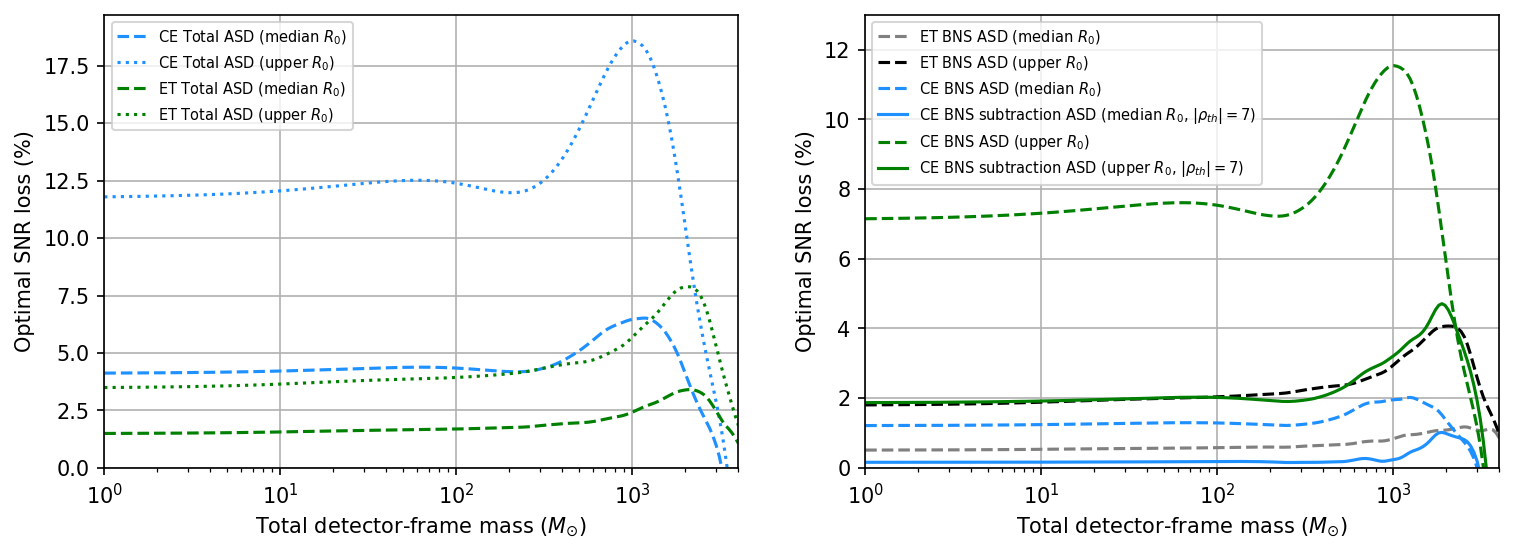

In [23]:
f = plt.figure(figsize=(12,4), dpi=150)
plt.rc('legend', fontsize=8)
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax1.semilogx(total_det_mass, np.array(opt_snr_loss_CE_median)*100, color='dodgerblue', linestyle='dashed', label=r'CE Total ASD (median $R_0$)')
ax1.semilogx(total_det_mass, np.array(opt_snr_loss_CE_upper)*100, color='dodgerblue', linestyle='dotted', label=r'CE Total ASD (upper $R_0$)')
ax1.semilogx(total_det_mass, np.array(opt_snr_loss_ET_median)*100, color='green', linestyle='dashed', label=r'ET Total ASD (median $R_0$)')
ax1.semilogx(total_det_mass, np.array(opt_snr_loss_ET_upper)*100, color='green', linestyle='dotted', label=r'ET Total ASD (upper $R_0$)')
ax1.set_xlabel(r"Total detector-frame mass ($M_{\odot}$)")
ax1.set_ylabel("Optimal SNR loss (%)")
ax1.set_xlim(1, 4000)
ax1.set_ylim(0, )
ax1.grid()
ax1.legend(fontsize=7)

ax2.semilogx(total_det_mass, np.array(opt_snr_loss_ETD_median_bns)*100, color='gray', linestyle='dashed', label=r'ET BNS ASD (median $R_0$)')
ax2.semilogx(total_det_mass, np.array(opt_snr_loss_ETD_upper_bns)*100, color='black', linestyle='dashed', label=r'ET BNS ASD (upper $R_0$)')

ax2.semilogx(total_det_mass, np.array(opt_snr_loss_CE_median_bns)*100, color='dodgerblue', linestyle='dashed', label=r'CE BNS ASD (median $R_0$)')
ax2.semilogx(total_det_mass, np.array(opt_snr_loss_CE_median_snr7p0_bns)*100, color='dodgerblue', linestyle='solid', label=r'CE BNS subtraction ASD (median $R_0$, $\left| \rho_{th} \right|=7$)')
ax2.semilogx(total_det_mass, np.array(opt_snr_loss_CE_upper_bns)*100, color='green', linestyle='dashed', label=r'CE BNS ASD (upper $R_0$)')
ax2.semilogx(total_det_mass, np.array(opt_snr_loss_CE_upper_snr7p0_bns)*100, color='green', linestyle='solid', label=r'CE BNS subtraction ASD (upper $R_0$, $\left| \rho_{th} \right|=7$)')

ax2.set_xlabel(r"Total detector-frame mass ($M_{\odot}$)")
ax2.set_ylabel("Optimal SNR loss (%)")
ax2.set_xlim(1, 4000)
ax2.set_ylim(0, 13)
ax2.grid()
ax2.legend(loc='upper left', fontsize=7)

f.savefig('optsnr_loss_CE_ET_detframe_totM_IMRPhenomD_all.pdf', dpi=500)
f.show()